# Εργαστήριο 6
Όπως και στα προηγούμενα εργαστήρια συνεχίζουμε στο περιβάλλον του [online chisel bootcamp](https://mybinder.org/v2/gh/freechipsproject/chisel-bootcamp/master).

Πριν ξεκινήσετε, εκτελέστε τα επόμενα 2 κελιά:

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-ivy.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

In [ ]:
import chisel3._
import chisel3.util._
import chisel3.tester._
import chisel3.tester.RawTester.test

## Ακολουθιακά κυκλώματα με στοιχεία μνήμης
Στα προηγούμενα παραδείγματα ασχοληθήκαμε με **συνδυαστικά** κυκλώματα, λογικές δηλαδή συναρτήσεις που ανάλογα με τις εισόδους που δέχονται παράγουν τις αντίστοιχες εξόδους.

Στα επεξεργαστικά συστήματα όμως η λειτουργία γίνεται βηματικά σε φάσεις που συγχρονίζονται από ένα η περισσότερα **σήματα ρολογιού** (clock). Μεταξύ των φάσεων πρέπει να κρατάμε τα προσωρινά αποτελέσματα σε "στοιχεία μνήμης" ή αλλιώς **καταχωρητές** (registers). Τα κυκλώματα που παράγουν αποτελέσματα με βάση προηγούμενη κατάσταση ονομάζονται **ακολουθιακά** κυκλώματα.

## Τι είναι ένα στοιχείο μνήμης (καταχωρητής)
Είναι ένα κύκλωμα που "αποθηκεύει" την τιμή μιας ομάδας bits. Το πόσα bits θα έχει ένας καταχωρητής εξαρτάται από τον σχεδιασμό μας για να καλύπτει τις ανάγκες μας. Υποθέστε ότι τα bits είναι `N` στον αριθμό.

Ένας καταχωρητής έχει τις ακόλουθες εισόδους-εξόδους:

* **Είσοδος δεδομένων**, με εύρος `Ν` bits
* **Έξοδος δεδομένων**, με εύρος πάλι `Ν` bits
* **Ρολόι (clock)**, με εύρος 1 bit

και ενδεχομένως τα πρόσθετα σήματα εισόδου:

* **Είσοδος reset**, με εύρος 1 bit, για να αρχικοποιούμε τον καταχωρητή σε γνωστή τιμή
* **Είσοδος enable**, με εύρος 1 bit, για να επιτρέπουμε ή όχι την εγγραφή νέων δεδομένων

## Περιγραφή λειτουργίας καταχωρητή
1. Ο καταχωρητής ανά πάσα στιγμή έχει μια **αποθηκευμένη τιμή**, η οποία εμφανίζεται στην **έξοδο δεδομένων**.
2. Η **είσοδος δεδομένων** μπορεί να έχει οποιαδήποτε τιμή, αυτή **δεν επηρεάζει** την αποθηκευμένη τιμή.
3. Κατά την **ανερχόμενη ακμή** του σήματος **clock** (όταν το clock από 0 γίνεται 1), η τιμή της **εισόδου δεδομένων** **εγγράφονται** στον καταχωρητή, διαγράφοντας τα παλιά δεδομένα.
4. Αμέσως μετά την αποθήκευση των νέων δεδομένων, αυτά εμφανίζονται και στην **έξοδο δεδομένων**.
5. Αν υπάρχει σήμα **enable**, αυτό θα πρέπει να είναι ενεργό (true) για να επιτραπεί η εγγραφή.
6. Αν υπάρχει **reset** και ενεργοποιηθεί, ο καταχωρητής παίρνει μια προκαθορισμένη τιμή. 

## Οι καταχωρητές στην Chisel
Μπορούμε να ορίσουμε έναν καταχωρητή με συγκεκριμένο εύρος στην Chisel ως εξής:
~~~scala
val testReg = Reg(UInt(8.W))
~~~
Στη συνέχεια συνδέουμε την είσοδο του καταχωρητή σε κάποιο άλλο σήμα, π.χ.
~~~scala
testReg := io.in
~~~
όπως επίσης και την έξοδο του καταχωρητή, π.χ.
~~~scala
io.out := testReg
~~~
**Προσοχή**: τα σήματα `clock` (και `reset`) **δεν τα γράφουμε εμείς**, τα παράγει αυτόματα η Chisel!

Δείτε το επόμενο παράδειγμα, όπου χρησιμοποιείται ένας καταχωρητής των 8 bits. Η είσοδος του module απλά συνδέεται στην είσοδο του καταχωρητή και, αντίστοιχα, η έξοδος του καταχωρητή συνδέεται στην έξοδο του module:

In [ ]:
class RegisterExample extends Module {
  val io = IO(new Bundle {
    val in = Input(UInt(8.W))
    val out = Output(UInt(8.W))
  })
  
  val testReg = Reg(UInt(8.W))
  
  testReg := io.in
  io.out := testReg
}

Στο test που ακολουθεί, χρησιμοποιούμε τη μέθοδο `peek()` για να τυπώσουμε τι υπάρχει στην έξοδο του κυκλώματος.

**Παρατηρήστε** πώς δίνουμε **έναν παλμό ρολογιού**:
~~~scala
c.clock.step()
~~~

In [ ]:
test(new RegisterExample()) { c =>
  println(c.io.out.peek())   // βλέπω την αρχική τιμή του καταχωρητή
  c.io.in.poke(123.U)        // αλλάζω την είσοδο
  println(c.io.out.peek())   // όσο το clock δεν ενεργοποιείται, συνεχίζω να βλέπω την αρχική τιμή 
  c.clock.step()             // δημιουργώ έναν παλμό ρολογιού
  println(c.io.out.peek())   // τώρα η είσοδος 123 θα αποθηκευτεί στον καταχωρητή και θα φανεί στην έξοδο 
}

Δείτε στην επόμενη **κυματομορφή** (waveform, η στάθμη των σημάτων στην εξέλιξη του χρόνου), πώς η έξοδος `io_out[7:0]` αλλάζει από την αρχική τιμή 0 σε 123 (7B hex) **μόνο όταν** το clock πάει από 0 σε 1 (μεταξύ 7ns και 14ns, όταν το reset δεν είναι ενεργό).

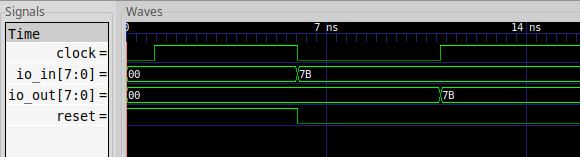

## Αρχικοποίηση καταχωρητή
Αν δεν ορίσουμε τιμή αρχικοποίησης ο καταχωρητής θα έχει μια αρχική τιμή (π.χ. 0) ανάλογα με την τεχνολογία υλοποίησης του κυκλώματος. Αν θέλουμε να ορίσουμε εμείς **μια συγκεκριμένη τιμή αρχικοποίησης** μπορούμε να δηλώσουμε τον καταχωρητή ως εξής:

~~~scala
val testReg = RegInit("hFF".U(8.W))
~~~
Στο επόμενο module βλέπουμε το ίδιο παράδειγμα όπως πριν, μόνο που εδώ ο καταχωρητής αρχικοποιείται στην τιμή FF(hex), ή αλλιώς οκτώ δυαδικά ψηφία με τιμή 1. 

In [ ]:
class RegisterExample extends Module {
  val io = IO(new Bundle {
    val in = Input(UInt(8.W))
    val out = Output(UInt(8.W))
  })
  
  val testReg = RegInit("hFF".U(8.W))
  
  testReg := io.in
  io.out := testReg
}

## Υλοποίηση μετρητών με καταχωρητές
Τα κυκλώματα **μετρητή** (counters) είναι βασικό στοιχείο των επεξεργαστικών συστημάτων. Μπορούμε να υλοποιήσουμε μετρητές με τη βοήθεια καταχωρητών.

Στο επόμενο παράδειγμα χρησιμοποιται ένας καταχωρητής με αρχική τιμή 0:
* Η είσοδος του καταχωρητή συνδέεται στην έξοδό του, αυξημένη κατά 1.

Κατά τη λειτουργία του κυκλώματος αυτού, σε κάθε παλμό του ρολογιού αποθηκεύεται στον καταχωρητή μια νέα τιμή, η οποία είναι η παλιά + 1. Συνεπώς στην έξοδο του κυκλώματος θα δούμε μια ακολουθία τιμών αυξανόμενη κατά 1.

*Σημ.: Όταν η τιμή μέτρησης θα φτάσει στη μέγιστη (255 ή FF(hex) για το εύρος των 8 bits), τότε η επόμενη τιμή θα επιστρέψει στο 0 κ.ο.κ.*


In [ ]:
class CounterExample extends Module {
  val io = IO(new Bundle {
    val out = Output(UInt(8.W))
  })
  
  val testReg = RegInit(0.U(8.W))
  
  testReg := testReg + 1.U
  io.out := testReg
}

Εκτελέστε το πιο κάτω test για να δείτε την αυξανόμενη ακολουθία τιμών στην έξοδο:

In [ ]:
test(new CounterExample()) { c =>
  
  println(c.io.out.peek())
  for (i <- 0 until 10) {
    c.clock.step()
    println(c.io.out.peek())
  }
    
}

## Άσκηση 1
Υλοποιήστε κύκλωμα μετρητή, ο οποίος έχει μια είσοδο `offset`. Συμπληρώστε στο επόμενο κελί τον κώδικα έτσι ώστε ο μετρητής να αυξάνεται **κατά offset** αντί για 1. Ο μετρητής θα πρέπει να ξεκινάει από την τιμή 0.

In [ ]:
class OffsetCounter extends Module {
  val io = IO(new Bundle {
    val offset = Input(UInt(8.W))
    val out = Output(UInt(8.W))
  })
  
  // συμπληρώστε...
    
}

Συμπληρώστε τον κατάλληλο κώδικα έτσι ώστε να τυπώνεται η ακολουθία τιμών αυξανόμενη κατά offset.

In [ ]:
test(new OffsetCounter()) { c =>

    // συμπληρώστε
    
}

## Άσκηση 2
Υλοποιήστε μετρητή με σήμα εισοδου `updown`. To σήμα αυτό ορίζεται ως boolean:
~~~scala
val updown = Input(Bool())
~~~
και παίρνει τιμές `true.B` ή `false.B`.

Όταν το `updown` είναι `true.B` ο μετρητής θα μετράει "προς τα πάνω" (+1). Στην αντίθετη περίπτωση θα μετράει "προς τα κάτω" (-1). Η αρχική τιμή του μετρητή θα είναι 0.

In [ ]:
class UpDownCounter extends Module {
  val io = IO(new Bundle {
    val updown = Input(Bool())
    val out = Output(UInt(8.W))
  })
  
  // συμπληρώστε...
    
}

Γράψτε τον κατάλληλο κώδικα στο test για να δείτε να τυπώνεται αυξανόμενη και μειούμενη ακολουθία τιμών στην έξοδο του μετρητή.

In [ ]:
test(new UpDownCounter()) { c =>

    // συμπληρώστε...
    
}